In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import pickle
from scipy.stats import uniform, randint
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
df=pd.read_csv('/content/drive/MyDrive/datasets/clean dataset.csv')

In [5]:
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [6]:
X = df.drop(['Churn'], axis=1)  # Replace 'target_column' with the name of your target variable
y = df['Churn']

sm = SMOTE()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)
y_train.value_counts()


,count
Churn,
0,4149
1,4149


In [ ]:
def evaluate_model(model_name, model, param_grid, X_train, y_train, X_test, y_test):

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    grid_search = GridSearchCV(model, param_grid, cv=2, verbose=0,scoring='accuracy')
    grid_search.fit(X_train, y_train)
    pipeline = grid_search.best_estimator_

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    accuracy_cv = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()

    accuracy_test = accuracy_score(y_test, y_pred)
    f1_test = f1_score(y_test, y_pred)
    auc_roc_test = roc_auc_score(y_test, y_pred)

    report = classification_report(y_test, y_pred)


    results = {
        'Model': model_name,
        'CV Accuracy': accuracy_cv,
        'Test Accuracy': accuracy_test,
        'Test F1 Score': f1_test,
        'Test AUC-ROC': auc_roc_test
    }

    feature_importances = None
    if  model_name in ['Random Forest', 'Gradient Boosting', 'Ada Boost', 'XG Boost', 'Decision Tree']:
        importances = pipeline.feature_importances_
        feature_names = X.columns
        feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)
        feature_imp_dict[model_name] = feature_importances

    elif model_name == 'Logistic Regression':
        coef = pipeline.coef_[0]
        feature_importances = pd.DataFrame(coef, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
        feature_imp_dict[model_name] = feature_importances

    elif model_name in ['K-Nearest Neighbors','Naive Bayes', 'Support Vector Machine']:
        result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)
        feature_importances = pd.DataFrame(result.importances_mean, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
        feature_imp_dict[model_name] = feature_importances

    # Print the performance metrics
    print(f"Model: {model_name}")
    print(f"Cross-Validation Accuracy: {accuracy_cv:.3f}")
    print(f"Test Accuracy: {accuracy_test:.3f}")
    print(f"Test F1 Score: {f1_test:.3f}")
    print(f"Test AUC-ROC: {auc_roc_test:.3f}")
    print()
    print(report)
    print('\t'+'-'*25+'\n')

    # Save the model to a pickle file
    with open(f'{model_name}.pkl', 'wb') as fp:
        pickle.dump(pipeline, fp)

    return results, feature_importances

In [ ]:
models = [
    ('Random Forest', RandomForestClassifier(random_state=42),
        {'n_estimators': [50, 100, 200],
         'max_depth': [None, 10, 20]}),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42),
        {'n_estimators': [50, 100, 200],
         'learning_rate': [0.05, 0.1, 0.5]}),
    ('Logistic Regression', LogisticRegression(random_state=42, class_weight='balanced'),
        {'C': [0.1, 1, 10],
         'penalty': ['l2']}),
    ('K-Nearest Neighbors', KNeighborsClassifier(),
        {'n_neighbors': [3, 5, 7],
         'weights': ['uniform', 'distance']}),
    ('Decision Tree', DecisionTreeClassifier(random_state=42),
        {'max_depth': [None, 10, 20],
         'min_samples_split': [2, 5, 10]}),
    ('XG Boost', XGBClassifier(random_state=42),
        {'max_depth': [5 , 7 ],
         'learning_rate': [0.01, 0.05, 0.1],
        }),
]


In [ ]:
model_results = []
feature_imp_dict = {}

for model_name, model, param_grid in models:
    results, feature_importances = evaluate_model(model_name, model, param_grid, X_train, y_train, X_test, y_test)
    model_results.append(results)
    if feature_importances is not None:
        feature_imp_dict[model_name] = feature_importances



Model: Random Forest
Cross-Validation Accuracy: 0.842
Test Accuracy: 0.782
Test F1 Score: 0.621
Test AUC-ROC: 0.747

              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1034
           1       0.58      0.67      0.62       375

    accuracy                           0.78      1409
   macro avg       0.73      0.75      0.73      1409
weighted avg       0.79      0.78      0.79      1409

	-------------------------

Model: Gradient Boosting
Cross-Validation Accuracy: 0.829
Test Accuracy: 0.769
Test F1 Score: 0.624
Test AUC-ROC: 0.754

              precision    recall  f1-score   support

           0       0.89      0.79      0.83      1034
           1       0.55      0.72      0.62       375

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.77      0.78      1409

	-------------------------

Model: Logistic Regression
Cross-Validation Accuracy

In [ ]:
results_df = pd.DataFrame(model_results)
results_df

,Model,CV Accuracy,Test Accuracy,Test F1 Score,Test AUC-ROC
0,Random Forest,0.842150,0.782115,0.621455,0.747025
1,Gradient Boosting,0.828623,0.769340,0.624277,0.753617
2,Logistic Regression,0.817633,0.779276,0.620269,0.746790
3,K-Nearest Neighbors,0.786594,0.699787,0.520951,0.672237
4,Decision Tree,0.812440,0.767921,0.608383,0.739054
5,XG Boost,0.838285,0.801987,0.630464,0.748668


# **BEST MODEL: XG Boost **

In [7]:
xg=XGBClassifier(random_state=42,max_depth=5,learning_rate=0.05)
xg.fit(X_train, y_train)
y_pred_xg=xg.predict(X_test)

In [8]:
xg_report=classification_report(y_test, y_pred_xg)
print(xg_report)

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1025
           1       0.66      0.60      0.63       384

    accuracy                           0.81      1409
   macro avg       0.76      0.74      0.75      1409
weighted avg       0.80      0.81      0.80      1409



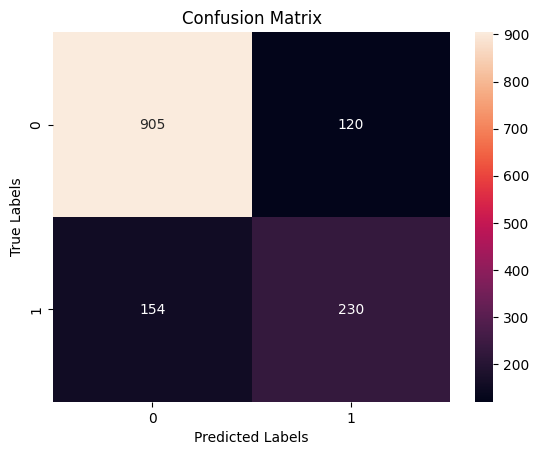

In [9]:
sns.heatmap(confusion_matrix(y_test, y_pred_xg), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

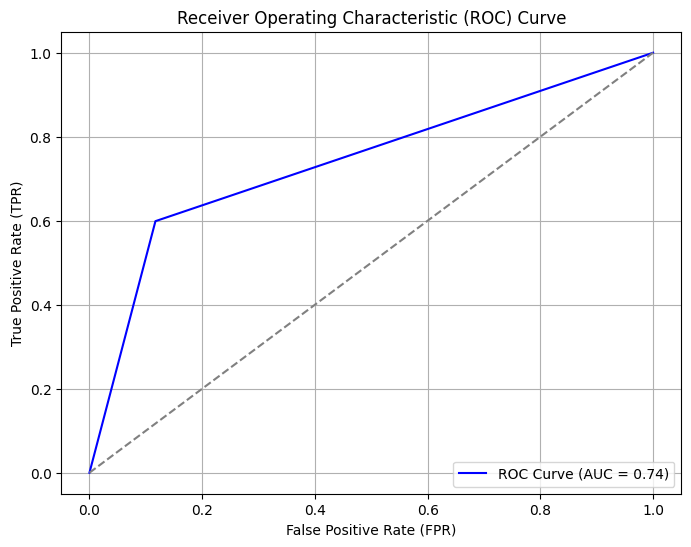

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

fpr, tpr, _ = roc_curve(y_test, y_pred_xg)
auc = roc_auc_score(y_test, y_pred_xg)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

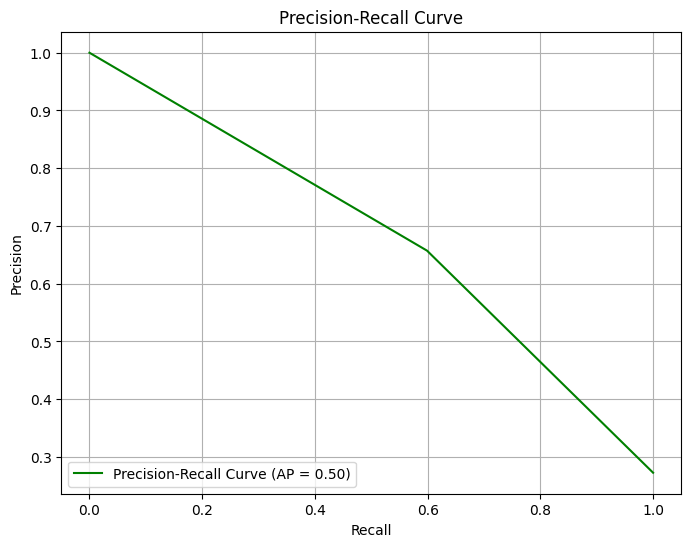

In [11]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_xg)
avg_precision = average_precision_score(y_test, y_pred_xg)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='g', label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [12]:
feature_imp_dict['XG Boost']

NameError: name 'feature_imp_dict' is not defined